# Autism Disorder Screening - Children #

## Found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Autistic+Spectrum+Disorder+Screening+Data+for+Children++)

- **Source**: *Fadi Fayez Thabtah*
<br>
    Department of Digital Technology
<br>
    Manukau Institute of Technology
<br>
    Auckland, New Zealand

In [1]:
import io
import os

from autism_data.arff_read import arff_to_df
from autism_data.arff_read import df_get_uniform_dummies
from ml_tools.scoring import log_loss

import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import os
plt.style.use('seaborn-notebook')

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

np.set_printoptions(suppress=True)

Using TensorFlow backend.


### Read in the data from UCI website and extract .arff file from zip folder

In [2]:
df = arff_to_df()
df2 = arff_to_df("https://archive.ics.uci.edu/ml/machine-learning-databases/00426/Autism-Adult-Data%20Plus%20Description%20File.zip",'Autism-Adult-Data.arff')
df3 = arff_to_df('https://archive.ics.uci.edu/ml/machine-learning-databases/00420/Autism-Adolescent-Data%20Plus%20Description.zip','Autism-Adolescent-Data.arff')

In [3]:
df = df.append([df2,df3])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 103
Data columns (total 20 columns):
A1_Score           1100 non-null category
A2_Score           1100 non-null category
A3_Score           1100 non-null category
A4_Score           1100 non-null category
A5_Score           1100 non-null category
A6_Score           1100 non-null category
A7_Score           1100 non-null category
A8_Score           1100 non-null category
A9_Score           1100 non-null category
A10_Score          1100 non-null category
age                1100 non-null float64
gender             1100 non-null category
ethnicity          1100 non-null object
jaundice           1100 non-null int64
autism             1100 non-null int64
used_app_before    1100 non-null int64
result             1100 non-null float64
age_range          1100 non-null object
relation           1100 non-null category
Class/ASD          1100 non-null int64
dtypes: category(12), float64(2), int64(4), object(2)
memory usage: 91.5

### Exploring the Data


In [5]:
df.ethnicity.value_counts()

White-European    381
Asian             185
Unknown           144
Middle_Eastern    128
Black              65
South_Asian        60
Others             57
Latino             33
Hispanic           25
Pasifika           14
Turkish             8
Name: ethnicity, dtype: int64

In [6]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,autism,used_app_before,result,age_range,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,6.0,m,Others,0,0,0,5.0,'4-11 years',Family Member,0
1,1,1,0,0,1,1,0,1,0,0,6.0,m,Middle_Eastern,0,0,0,5.0,'4-11 years',Family Member,0
2,1,1,0,0,0,1,1,1,0,0,6.0,m,Unknown,0,0,1,5.0,'4-11 years',Unknown,0
3,0,1,0,0,1,1,0,0,0,1,5.0,f,Unknown,1,0,0,4.0,'4-11 years',Unknown,0
4,1,1,1,1,1,1,1,1,1,1,5.0,m,Others,1,0,0,10.0,'4-11 years',Family Member,1


In [7]:
for column in list(df.columns):
    print(column,": ",df[column].nunique())

A1_Score :  2
A2_Score :  2
A3_Score :  2
A4_Score :  2
A5_Score :  2
A6_Score :  2
A7_Score :  2
A8_Score :  2
A9_Score :  2
A10_Score :  2
age :  59
gender :  2
ethnicity :  11
jaundice :  2
autism :  2
used_app_before :  2
result :  11
age_range :  4
relation :  4
Class/ASD :  2


In [8]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'autism', 'used_app_before', 'result',
       'age_range', 'relation', 'Class/ASD'],
      dtype='object')

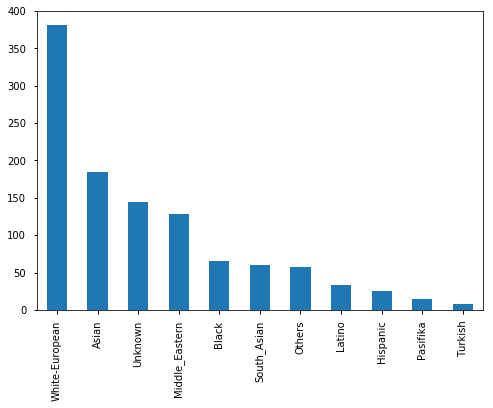

In [9]:
df.ethnicity.value_counts().plot(kind='bar')
plt.show()

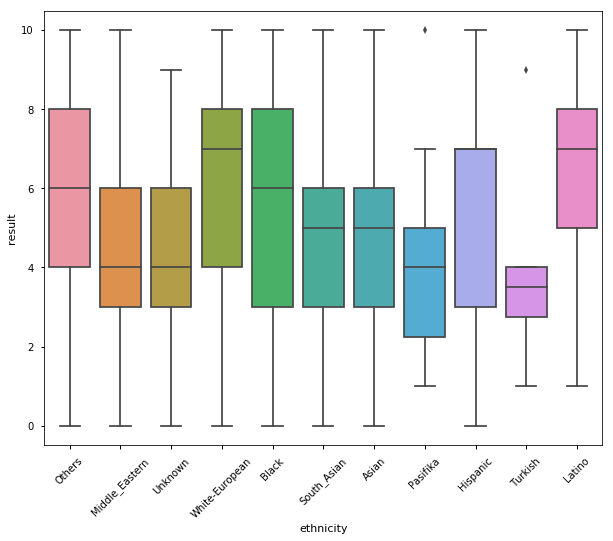

In [10]:
plt.figure(figsize=(10,8))
sb.boxplot(x='ethnicity',y='result',data=df)
plt.xticks(rotation=45)
plt.show()

In [11]:
df.result.value_counts()

4.0     174
3.0     136
5.0     129
6.0     126
8.0     121
7.0     118
9.0      98
2.0      85
10.0     56
1.0      42
0.0      15
Name: result, dtype: int64

In [12]:
df['age_range'] = pd.cut(df.age,[4,11,17,max(df.age)],labels=['4-11 years','12-17 years','18 and older'],right=True)

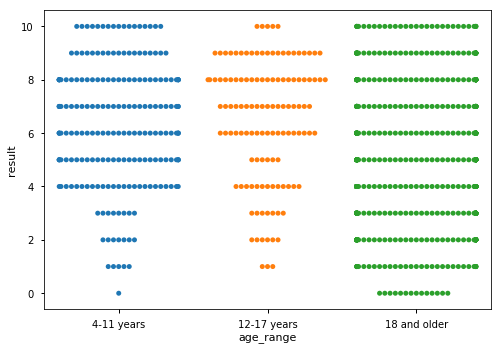

In [13]:
sb.swarmplot(x='age_range',y='result',data=df)
plt.show()

### Exploring the data, some conclusions:
    - Scoring 7 or higher is associated with Autism diagnosis
    - Some interesting differences between ethnicities, but not clear if that is meaningful

In [14]:
df.relation.unique()

[Family Member, Unknown, Self, Health care professional]
Categories (4, object): [Family Member, Unknown, Self, Health care professional]

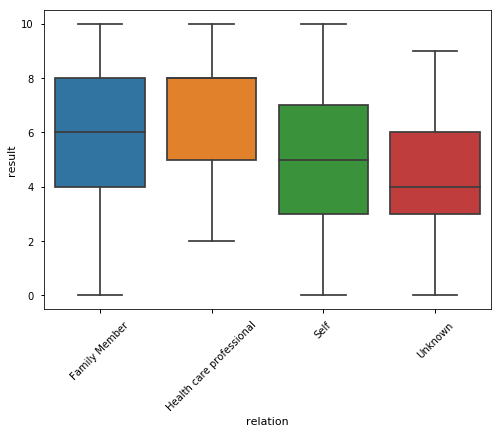

In [15]:
sb.boxplot(x='relation',y='result',data=df)
plt.xticks(rotation=45)
plt.show()

In [16]:
df = df.drop(['result','age'],axis=1)

In [17]:
binary_df = df_get_uniform_dummies(df)
binary_df = binary_df.iloc[:,10:]
binary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 103
Data columns (total 20 columns):
jaundice                        1100 non-null int64
autism                          1100 non-null int64
used_app_before                 1100 non-null int64
Class/ASD                       1100 non-null int64
gen_m                           1100 non-null int64
eth_Black                       1100 non-null int64
eth_Hispanic                    1100 non-null int64
eth_Latino                      1100 non-null int64
eth_Middle_Eastern              1100 non-null int64
eth_Others                      1100 non-null int64
eth_Pasifika                    1100 non-null int64
eth_South_Asian                 1100 non-null int64
eth_Turkish                     1100 non-null int64
eth_Unknown                     1100 non-null int64
eth_White-European              1100 non-null int64
age_12-17 years                 1100 non-null int64
age_18 and older                1100 non-null int64
rel_Health

** Now we are ready for machine learning! **

### Bernoulli Naive Bayes Classifier (good for binary features)

In [18]:
bern = BernoulliNB()

In [19]:
#feature_columns = binary_df.drop(['Class/ASD'],axis=1).columns
features_df = binary_df.drop(['Class/ASD'],axis=1)
feature_names = features_df.columns
features = features_df.as_matrix()
target = binary_df.loc[:,['Class/ASD']].values.reshape(len(binary_df),)

In [20]:
feature_names

Index(['jaundice', 'autism', 'used_app_before', 'gen_m', 'eth_Black',
       'eth_Hispanic', 'eth_Latino', 'eth_Middle_Eastern', 'eth_Others',
       'eth_Pasifika', 'eth_South_Asian', 'eth_Turkish', 'eth_Unknown',
       'eth_White-European', 'age_12-17 years', 'age_18 and older',
       'rel_Health care professional', 'rel_Self', 'rel_Unknown'],
      dtype='object')

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features,target,random_state=12)

In [22]:
bern.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [23]:
bern_y_pred = bern.predict(X_test)
bern_y_pred_proba = bern.predict_proba(X_test)
#print(len(bern_y_pred[bern_y_pred == y_test])/len(y_test))

In [24]:
precision_score(bern_y_pred,y_test)

0.5

In [25]:
accuracy_score(bern_y_pred,y_test)

0.71272727272727276

In [26]:
bern_log_loss = log_loss(bern_y_pred_proba[:,1],y_test)
bern_fp, bern_tp, bern_thresholds = roc_curve(y_test,bern_y_pred_proba[:,1])
bern_AUC = round(roc_auc_score(y_test,bern_y_pred_proba[:,1]),2)

### Logistic Regression

In [27]:
logreg = LogisticRegression(C=.1)

In [28]:
logreg.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
y_logreg_pred = logreg.predict(X_test)

In [30]:
y_logreg_pred

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=int64)

In [31]:
accuracy_score(y_logreg_pred,y_test)

0.70545454545454545

In [32]:
precision_score(y_logreg_pred,y_test)

0.33333333333333331

In [33]:
y_logreg_pred_proba = logreg.predict_proba(X_test)

In [34]:
logreg_log_loss = log_loss(y_logreg_pred_proba[:,1],y_test)
log_fp, log_tp, log_thresholds = roc_curve(y_test,y_logreg_pred_proba[:,1])
log_AUC = round(roc_auc_score(y_test,y_logreg_pred_proba[0:,1]),2)

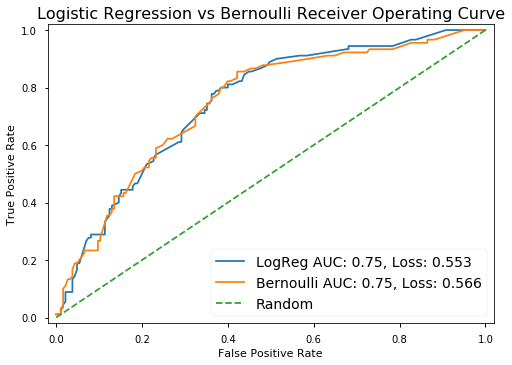

In [35]:
ax = plt.plot(log_fp,log_tp,label="LogReg AUC: {}, Loss: {}".format(log_AUC,round(logreg_log_loss,3)))
ax = plt.plot(bern_fp,bern_tp,label="Bernoulli AUC: {}, Loss: {}".format(bern_AUC,round(bern_log_loss,3)))
ax = plt.plot([0,1],[0,1],linestyle='--',label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0,fontsize=14)
plt.title('Logistic Regression vs Bernoulli Receiver Operating Curve',fontsize=16)
plt.margins(0.02)
plt.show()

In [36]:
roc_auc_score(y_test,y_logreg_pred_proba[0:,1])

0.74897897897897903

### K-Neighbors Classifier

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
neighbors = np.arange(1,10)

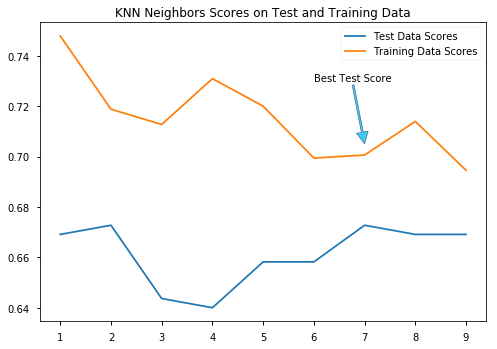

In [39]:
test_scores = np.empty(len(neighbors))
train_scores = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    test_scores[i] = knn.score(X_test,y_test)
    train_scores[i] = knn.score(X_train,y_train)
    
plt.plot(neighbors,test_scores,label='Test Data Scores')
plt.plot(neighbors,train_scores,label='Training Data Scores')
plt.title('KNN Neighbors Scores on Test and Training Data')
plt.annotate('Best Test Score',xy=(7,.705),xytext=(6,.73),arrowprops={'facecolor':'#42c5f4','width':2})
plt.legend(loc=0)
plt.show()

In [40]:
knn = KNeighborsClassifier(n_neighbors=7)

In [41]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [42]:
knn_y_pred = knn.predict(X_test)

In [43]:
knn.score(X_train,y_train)

0.70060606060606057

In [44]:
knn_pred_proba = knn.predict_proba(X_test)
knn_fp, knn_tp, knn_thresholds = roc_curve(y_test,knn_pred_proba[:,1])
knn_AUC = round(roc_auc_score(y_test,knn_pred_proba[:,1]),2)

In [45]:
knn.score(X_test,y_test)

0.67272727272727273

In [46]:
knn_log_loss = log_loss(knn_pred_proba[:,1],y_test)

### Using Decision Tree Classifier ###

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
tree = DecisionTreeClassifier(min_samples_leaf=10)

In [49]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [50]:
tree_y_pred = tree.predict(X_test)
tree_y_pred_proba = tree.predict_proba(X_test)

In [51]:
tree.score(X_test,y_test)

0.66181818181818186

In [52]:
tree_log_loss = log_loss(tree_y_pred_proba[:,1],y_test)
tree_fp,tree_tp, thresholds = roc_curve(y_test,tree_y_pred_proba[:,1])
tree_AUC = round(roc_auc_score(y_test,tree_y_pred_proba[0:,1]),2)

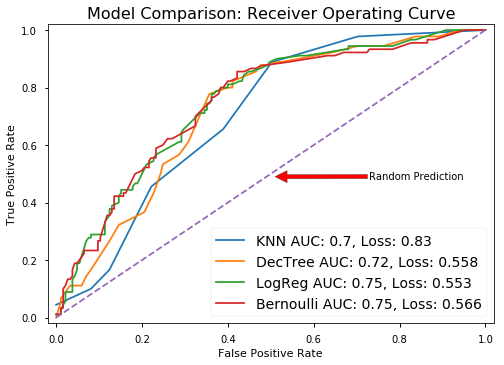

In [53]:
log_AUC = round(roc_auc_score(y_test,y_logreg_pred_proba[0:,1]),2)

ax = plt.plot(knn_fp,knn_tp,label="KNN AUC: {}, Loss: {}".format(knn_AUC,round(knn_log_loss,3)))
ax = plt.plot(tree_fp,tree_tp,label="DecTree AUC: {}, Loss: {}".format(tree_AUC,round(tree_log_loss,3)))
ax = plt.plot(log_fp,log_tp,label="LogReg AUC: {}, Loss: {}".format(log_AUC,round(logreg_log_loss,3)))
ax = plt.plot(bern_fp,bern_tp,label="Bernoulli AUC: {}, Loss: {}".format(bern_AUC,round(bern_log_loss,3)))
ax = plt.plot([0,1],[0,1],linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0,fontsize=14)
plt.title('Model Comparison: Receiver Operating Curve',fontsize=16)
plt.margins(0.02)
plt.annotate("Random Prediction",xy=(.51,.49),xytext=(.73,.48),arrowprops={'facecolor':'red'})
plt.show()

### So far, Logistic Regression provides the most accurate model

In [54]:
mat = np.array([[3,2,5],[6,1,4]])

In [55]:
mat

array([[3, 2, 5],
       [6, 1, 4]])

In [56]:
mat.T

array([[3, 6],
       [2, 1],
       [5, 4]])

In [57]:
mat2 = np.array([[2,4],[1,3],[0,0],[0,0]])

In [58]:
mat2

array([[2, 4],
       [1, 3],
       [0, 0],
       [0, 0]])

In [59]:
mat2.T

array([[2, 1, 0, 0],
       [4, 3, 0, 0]])

In [60]:
prod = mat2 @ mat2.T

In [61]:
prod.diagonal()

array([20, 10,  0,  0])

In [62]:
np.linalg.eig(prod)

(array([ 29.86606875,   0.13393125,   0.        ,   0.        ]),
 array([[ 0.81741556, -0.57604844,  0.        ,  0.        ],
        [ 0.57604844,  0.81741556,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [63]:
w, v = np.linalg.eig(prod)

In [64]:
vec = np.sqrt(w)

In [65]:
eigen_vec = np.diag(vec)[:mat2.shape[0],:mat2.shape[1]]

In [66]:
def singular_value_decomposition(matrix):
    w, v = np.linalg.eig(matrix @ matrix.T)
    svd = np.diag(np.sqrt(w))[:matrix.shape[1],:matrix.shape[1]]
    return svd

In [67]:
singular_value_decomposition(mat2)

array([[ 5.4649857 ,  0.        ],
       [ 0.        ,  0.36596619]])

### Trying out Neural Network Model to Improve Predictions

In [68]:
feature_columns = features.shape[1]

target_split = to_categorical(target)

In [69]:
nnX_train, nnX_test, nny_train, nny_test = train_test_split(features,target_split,random_state=12)

In [70]:
model = Sequential()

In [71]:
model.add(Dense(100,activation='relu',input_shape=(feature_columns,)))

In [72]:
model.add(Dense(2,activation='softmax'))

In [73]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [74]:
model_training = model.fit(nnX_train,nny_train,batch_size=50,epochs=120)

Epoch 1/120
825/825 [==============================] - 0s 484us/step - loss: 0.6347 - acc: 0.6533
Epoch 2/120
825/825 [==============================] - 0s 58us/step - loss: 0.6001 - acc: 0.6606
Epoch 3/120
825/825 [==============================] - 0s 52us/step - loss: 0.5868 - acc: 0.6558
Epoch 4/120
825/825 [==============================] - 0s 34us/step - loss: 0.5794 - acc: 0.6739
Epoch 5/120
825/825 [==============================] - 0s 50us/step - loss: 0.5732 - acc: 0.6788
Epoch 6/120
825/825 [==============================] - 0s 35us/step - loss: 0.5692 - acc: 0.6873
Epoch 7/120
825/825 [==============================] - 0s 46us/step - loss: 0.5660 - acc: 0.6897
Epoch 8/120
825/825 [==============================] - 0s 38us/step - loss: 0.5640 - acc: 0.6921
Epoch 9/120
825/825 [==============================] - 0s 35us/step - loss: 0.5610 - acc: 0.6897
Epoch 10/120
825/825 [==============================] - 0s 49us/step - loss: 0.5581 - acc: 0.7018
Epoch 11/120
825/825 [======

825/825 [==============================] - 0s 36us/step - loss: 0.4978 - acc: 0.7442
Epoch 85/120
825/825 [==============================] - 0s 36us/step - loss: 0.4966 - acc: 0.7515
Epoch 86/120
825/825 [==============================] - ETA: 0s - loss: 0.5539 - acc: 0.660 - 0s 34us/step - loss: 0.4973 - acc: 0.7406
Epoch 87/120
825/825 [==============================] - 0s 43us/step - loss: 0.4961 - acc: 0.7539
Epoch 88/120
825/825 [==============================] - 0s 40us/step - loss: 0.4950 - acc: 0.7370
Epoch 89/120
825/825 [==============================] - 0s 41us/step - loss: 0.4944 - acc: 0.7467
Epoch 90/120
825/825 [==============================] - 0s 39us/step - loss: 0.4946 - acc: 0.7491
Epoch 91/120
825/825 [==============================] - 0s 40us/step - loss: 0.4950 - acc: 0.7442
Epoch 92/120
825/825 [==============================] - 0s 39us/step - loss: 0.4925 - acc: 0.7552
Epoch 93/120
825/825 [==============================] - 0s 41us/step - loss: 0.4933 - acc: 0.

In [75]:
nn_predict_proba = model.predict_proba(nnX_test)
nn_predict_proba

array([[ 0.59572172,  0.40427831],
       [ 0.3928636 ,  0.60713637],
       [ 0.75187325,  0.2481267 ],
       [ 0.3928636 ,  0.60713637],
       [ 0.70226103,  0.29773897],
       [ 0.3443583 ,  0.65564173],
       [ 0.0800258 ,  0.91997421],
       [ 0.84080029,  0.15919973],
       [ 0.0558317 ,  0.94416833],
       [ 0.49753729,  0.50246263],
       [ 0.99489236,  0.00510768],
       [ 0.41481274,  0.58518726],
       [ 0.6502564 ,  0.34974355],
       [ 0.55693609,  0.44306391],
       [ 0.94968981,  0.05031023],
       [ 0.43813586,  0.56186414],
       [ 0.8724761 ,  0.12752394],
       [ 0.8724761 ,  0.12752394],
       [ 0.09971073,  0.90028924],
       [ 0.8724761 ,  0.12752394],
       [ 0.05452533,  0.94547468],
       [ 0.90996104,  0.09003895],
       [ 0.93495363,  0.06504636],
       [ 0.54313761,  0.45686236],
       [ 0.36778191,  0.63221812],
       [ 0.38310531,  0.61689466],
       [ 0.36778191,  0.63221812],
       [ 0.93495363,  0.06504636],
       [ 0.93369782,

In [76]:
model.evaluate(nnX_test,nny_test,batch_size=50)

275/275 [==============================] - 0s 153us/step


[0.61984537406401197, 0.67636364156549622]

In [77]:
nn_log_loss = log_loss(nn_predict_proba[:,1],nny_test[:,1])
nn_fpr, nn_tpr, nn_thresh = roc_curve(nny_test[:,1],nn_predict_proba[:,1])
nn_AUC = round(roc_auc_score(nny_test[:,1],nn_predict_proba[:,1]),2)

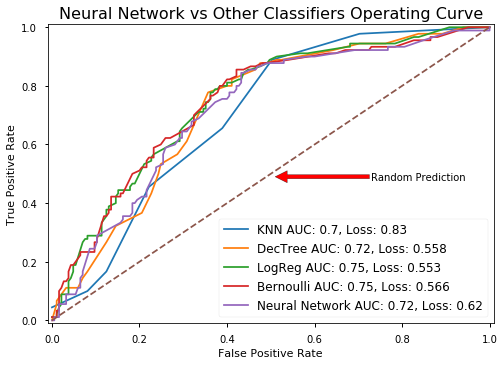

In [78]:
ax = plt.plot(knn_fp,knn_tp,label="KNN AUC: {}, Loss: {}".format(knn_AUC,round(knn_log_loss,3)))
ax = plt.plot(tree_fp,tree_tp,label="DecTree AUC: {}, Loss: {}".format(tree_AUC,round(tree_log_loss,3)))
ax = plt.plot(log_fp,log_tp,label="LogReg AUC: {}, Loss: {}".format(log_AUC,round(logreg_log_loss,3)))
ax = plt.plot(bern_fp,bern_tp,label="Bernoulli AUC: {}, Loss: {}".format(bern_AUC,round(bern_log_loss,3)))
ax = plt.plot(nn_fpr,nn_tpr,label="Neural Network AUC: {}, Loss: {}".format(nn_AUC,round(nn_log_loss,3)))
ax = plt.plot([0,1],[0,1],linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0,fontsize=12)
plt.title('Neural Network vs Other Classifiers Operating Curve',fontsize=16)
plt.margins(0.01)
plt.annotate("Random Prediction",xy=(.51,.49),xytext=(.73,.48),arrowprops={'facecolor':'red'})
plt.show()

### Looking at the Epoch history of Neural Network model

In [79]:
nn_history = pd.DataFrame(model_training.history)

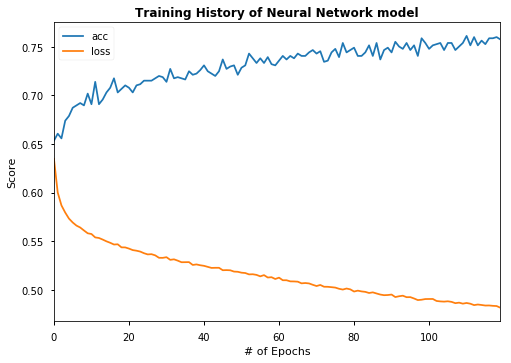

In [80]:
nn_history.plot()
plt.xlabel('# of Epochs')
plt.ylabel('Score')
plt.title('Training History of Neural Network model',fontweight='bold')
plt.show()

In [81]:
from sklearn.model_selection import GridSearchCV

In [82]:
param_grid = {'C':[.0001,.001,.01,.1,1,10,100]}
param_grid

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

In [83]:
logreg_cv = GridSearchCV(LogisticRegression(),param_grid,cv=5)

In [84]:
logreg_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [85]:
logreg_cv.best_params_

{'C': 1}

### Saving Logistic Regression model and Predictions DataFrame

In [86]:
from sklearn.externals import joblib

In [87]:
joblib.dump(logreg,'autism_screening_logistic_regression_model.pkl')

['autism_screening_logistic_regression_model.pkl']

In [88]:
model_loaded = joblib.load('autism_screening_logistic_regression_model.pkl')

In [89]:
(y_logreg_pred_proba).all() == (model_loaded.predict_proba(X_test)).all()

True

In [90]:
predictions_df = pd.DataFrame(data=X_test,columns=feature_names)

In [91]:
target_df = pd.DataFrame({'Predicted Probability':y_logreg_pred_proba[:,1],
                          'Predicted Outcome':y_logreg_pred})

In [92]:
target_df['Risk Level'] = pd.cut(target_df['Predicted Probability'],[0,.25,.5,.75,1],right=False,labels=['Very Unlikely','Unlikely','Likely','Very Likely'])

In [93]:
predictions_df = pd.concat([predictions_df,target_df],axis=1)

In [94]:
predictions_df.head()

,jaundice,autism,used_app_before,gen_m,eth_Black,eth_Hispanic,eth_Latino,eth_Middle_Eastern,eth_Others,eth_Pasifika,...,eth_Unknown,eth_White-European,age_12-17 years,age_18 and older,rel_Health care professional,rel_Self,rel_Unknown,Predicted Outcome,Predicted Probability,Risk Level
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0.339054,Unlikely
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0.420104,Unlikely
2,1,1,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0.212794,Very Unlikely
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0.420104,Unlikely
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0.299095,Unlikely


In [95]:
predictions_df.to_csv('autism_screening_predictions.csv')

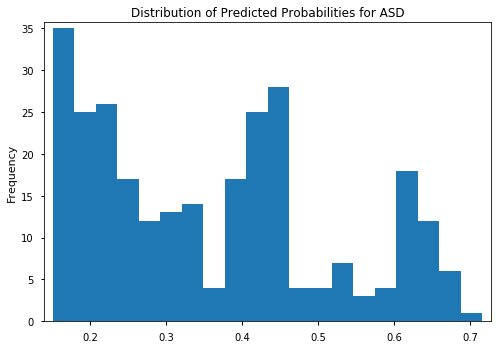

In [96]:
predictions_df['Predicted Probability'].plot(kind='hist',bins=20,title='Distribution of Predicted Probabilities for ASD')
plt.margins(0.02)
plt.show()